# **Fraud Detection in Mobile Banking**

In [4]:
#importing math libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra

#importing data visulazation libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#modeling libraries
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

#libraries for model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv


In [5]:
data=pd.read_csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Information about Banking Dataset

In [6]:
#shape of the dataset
data.shape

(6362620, 11)

In [7]:
#Datatype of the attributes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
#statistical analysis of the dataset
data.describe().round(2)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6.362620e+06,6.362620e+06,6362620.00,6362620.0
mean,243.40,179861.90,833883.10,855113.67,1.100702e+06,1.224996e+06,0.00,0.0
std,142.33,603858.23,2888242.67,2924048.50,3.399180e+06,3.674129e+06,0.04,0.0
min,1.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
25%,156.00,13389.57,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
50%,239.00,74871.94,14208.00,0.00,1.327057e+05,2.146614e+05,0.00,0.0
75%,335.00,208721.48,107315.18,144258.41,9.430367e+05,1.111909e+06,0.00,0.0
max,743.00,92445516.64,59585040.37,49585040.37,3.560159e+08,3.561793e+08,1.00,1.0


> We can see, mean of many columns are higher than the median of the columns and the Max value of the attributes is higher than 75% percentile data. This indicates the presence of outliers in some attributes. 

# Exploratory Data Analysis

In [9]:
#checking for null values
data.isnull().values.any()

False

In [10]:
#Checking if there are any missing values
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

> No Missing values found in the dataset

In [11]:
#unique values in columns(to check if there are any invalid characters/objects )
for col in data.columns:
    print('{}:{}'.format(col,data[col].unique()))

step:[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 2

> From this we conclude we that dont have any special or invalid charater on the attribues of the dataset.

**Renaming some columns for easy understanding of the dataset**

In [12]:
data = data.rename(columns = {'nameOrig' : 'sender', 'oldbalanceOrg' : 'sender_old_balance', 'newbalanceOrig': 'sender_new_balance', 'nameDest' : 'receiver', 'oldbalanceDest' : 'receiver_old_balance', 'newbalanceDest': 'receiver_new_balance'})
data.head()

,step,type,amount,sender,sender_old_balance,sender_new_balance,receiver,receiver_old_balance,receiver_new_balance,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


> Since our objective is to predict whether a transaction is fraud or not we will use the target column as **isFraud**  

In [13]:
#Number of Fraud and Non-fraud in the dataset
data.isFraud.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

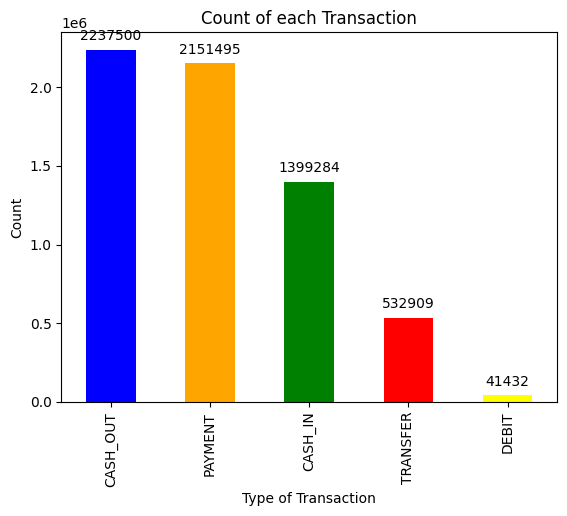

In [14]:
data_type=data.type.value_counts()

# Ploting the bar chart
chart = data_type.plot(kind='bar', color=['blue', 'orange', 'green', 'red', 'yellow'])

# plotting bars with count values
for p in chart.patches:
    chart.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xlabel('Type of Transaction')
plt.ylabel('Count')
plt.title('Count of each Transaction')

# Show the plot
plt.show()

> Maximum transactions were of type CASH_OUT

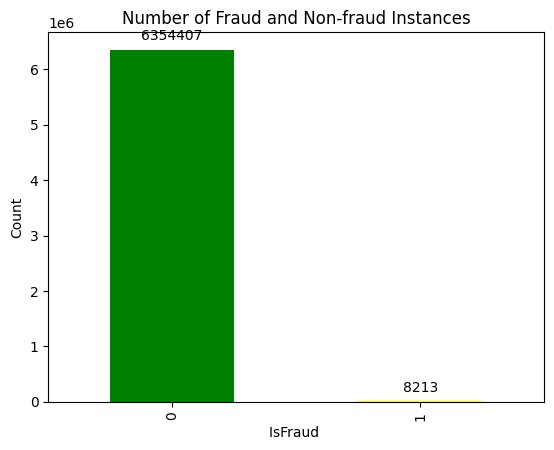

In [15]:
# count of Fraud and Non-fraud
fraud_counts = data['isFraud'].value_counts()


# Ploting bar chart
plot = fraud_counts.plot(kind='bar', color=['Green', 'yellow'])

# bars with count values
for p in plot.patches:
    plot.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')


plt.xlabel('IsFraud ')
plt.ylabel('Count')
plt.title('Number of Fraud and Non-fraud Instances')

# Show the plot
plt.show()

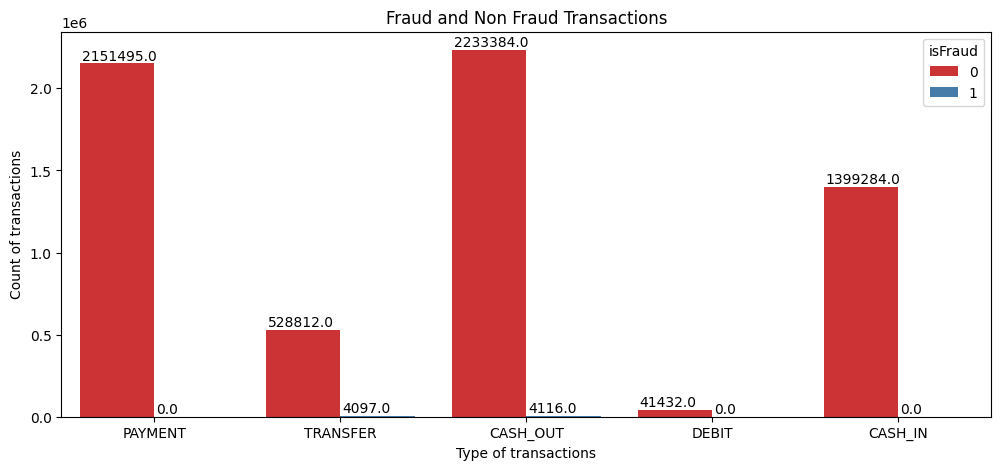

In [16]:
#what type of transactions were regeared as fraud?

plt.figure(figsize = (12, 5))
plot=sns.countplot(data = data, x = "type", hue="isFraud", palette = 'Set1')
plt.title('Fraud and Non Fraud Transactions')
plt.xlabel('Type of transactions')
plt.ylabel('Count of transactions')
for p in plot.patches:
        plot.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+20000))

> We can see the fradulent transaction are of the type: **TRANSFER** and **CASH_OUT**

In [17]:
fraud_positive_data=data.query('isFraud==1')
fraud_positive_data.head(10)

,step,type,amount,sender,sender_old_balance,sender_new_balance,receiver,receiver_old_balance,receiver_new_balance,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.0,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.0,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.0,0.00,1,0
681,1,CASH_OUT,20128.00,C1118430673,20128.00,0.0,C339924917,6268.0,12145.85,1,0
724,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.0,9291619.62,1,0
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.0,0.00,1,0
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.0,2444985.19,1,0
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.0,C1136419747,0.0,0.00,1,0


> We observed that most of the fraud transactions took place where the sender and receiver were both customers 

**Correlation between attributes**

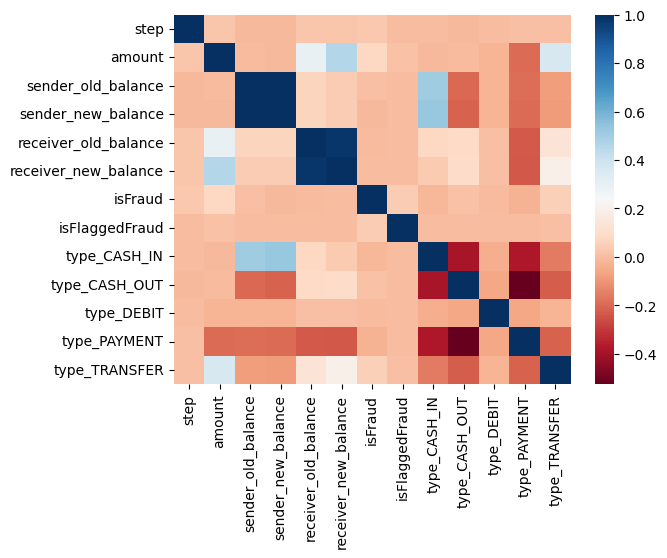

In [18]:
data1=data.drop(['sender','receiver'], axis=1)
encoded_data=pd.get_dummies(data1)
sns.heatmap(encoded_data.corr(),cmap='RdBu');

In [19]:
encoded_data.corr().round(2)

,step,amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
step,1.00,0.02,-0.01,-0.01,0.03,0.03,0.03,0.00,0.00,-0.01,0.00,0.00,0.01
amount,0.02,1.00,-0.00,-0.01,0.29,0.46,0.08,0.01,-0.01,-0.00,-0.02,-0.20,0.37
sender_old_balance,-0.01,-0.00,1.00,1.00,0.07,0.04,0.01,0.00,0.51,-0.20,-0.02,-0.19,-0.08
sender_new_balance,-0.01,-0.01,1.00,1.00,0.07,0.04,-0.01,0.00,0.53,-0.21,-0.02,-0.19,-0.09
receiver_old_balance,0.03,0.29,0.07,0.07,1.00,0.98,-0.01,-0.00,0.08,0.09,0.01,-0.23,0.13
receiver_new_balance,0.03,0.46,0.04,0.04,0.98,1.00,0.00,-0.00,0.03,0.09,0.01,-0.24,0.19
isFraud,0.03,0.08,0.01,-0.01,-0.01,0.00,1.00,0.04,-0.02,0.01,-0.00,-0.03,0.05
isFlaggedFraud,0.00,0.01,0.00,0.00,-0.00,-0.00,0.04,1.00,-0.00,-0.00,-0.00,-0.00,0.01
type_CASH_IN,0.00,-0.01,0.51,0.53,0.08,0.03,-0.02,-0.00,1.00,-0.39,-0.04,-0.38,-0.16
type_CASH_OUT,-0.01,-0.00,-0.20,-0.21,0.09,0.09,0.01,-0.00,-0.39,1.00,-0.06,-0.53,-0.22


> It can be seen that there is no strong correlation between the fradulent and other attributes, and some columns can be dropped since it don't affect the target variable (isFraud)

> We also conclude that since there is not strong correlation, we need a new feature which corelates more closely with the fradulent transactions  

# Pre-Processing

> Now we can do feature engineering to introduce another column which have strong correlation with the fraudlent data which proved to be helpful for later Machine Learning tasks.

In [20]:
process_data = data.copy()
process_data['sender_receiver'] = np.nan
process_data.loc[data.sender.str.contains('C') & process_data.receiver.str.contains('C'), 'sender_receiver'] = 'C-C'
process_data.loc[data.sender.str.contains('C') & process_data.receiver.str.contains('M'), 'sender_receiver'] = 'C-M'
process_data.loc[data.sender.str.contains('M') & process_data.receiver.str.contains('C'), 'sender_receiver'] = 'M-C'
process_data.loc[data.sender.str.contains('M') & process_data.receiver.str.contains('C'), 'sender_receiver'] = 'M-M'

1. Balancing the target
From the pie chart below we can clearly see that the target label is heavily imbalance as we have only 0.2% of fraudulent data which is in-sufficient for machine to learn and flag when fraud transactions happen.

**Distribution of the target label in the Dataset**

In [21]:
fraud_data=process_data.copy()

#Checking for balance in target
pie_fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=fraud_data['isFraud'].value_counts())])
pie_fig.show()

> Since the target is highly skewed , we perform oversampling to increase the number of frauds datapoints 

In [22]:
#Getting the max size ie. the number of non-frauds
max_size = fraud_data['isFraud'].value_counts().max()

#Balancing the target label
lst = [fraud_data]
for class_index, group in fraud_data.groupby('isFraud'):
    lst.append(group.sample(max_size-len(group), replace=True))
fraud_data = pd.concat(lst)

In [23]:
# target distribution
pie_fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=fraud_data['isFraud'].value_counts())])
pie_fig.show()

**One hot encoding**
One of the most important feature we have is type which is categorical. Since it doesnt have any ordinal nature and and the classes are less, we prefer applying one hot encoding.

> So our final dataset is fraud_data which have normal distribution on the target variable isFraud

In [24]:
fraud_data.head()

,step,type,amount,sender,sender_old_balance,sender_new_balance,receiver,receiver_old_balance,receiver_new_balance,isFraud,isFlaggedFraud,sender_receiver
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,C-M
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,C-M
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,C-C
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,C-C
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,C-M


In [26]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12708814 entries, 0 to 4930982
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   step                  int64  
 1   type                  object 
 2   amount                float64
 3   sender                object 
 4   sender_old_balance    float64
 5   sender_new_balance    float64
 6   receiver              object 
 7   receiver_old_balance  float64
 8   receiver_new_balance  float64
 9   isFraud               int64  
 10  isFlaggedFraud        int64  
 11  sender_receiver       object 
dtypes: float64(5), int64(3), object(4)
memory usage: 1.2+ GB


**Dropping irrelavent features/attributes from the dataset**

In [27]:
fraud_data=fraud_data.drop(columns=['sender','receiver', 'isFlaggedFraud'], axis='columns')

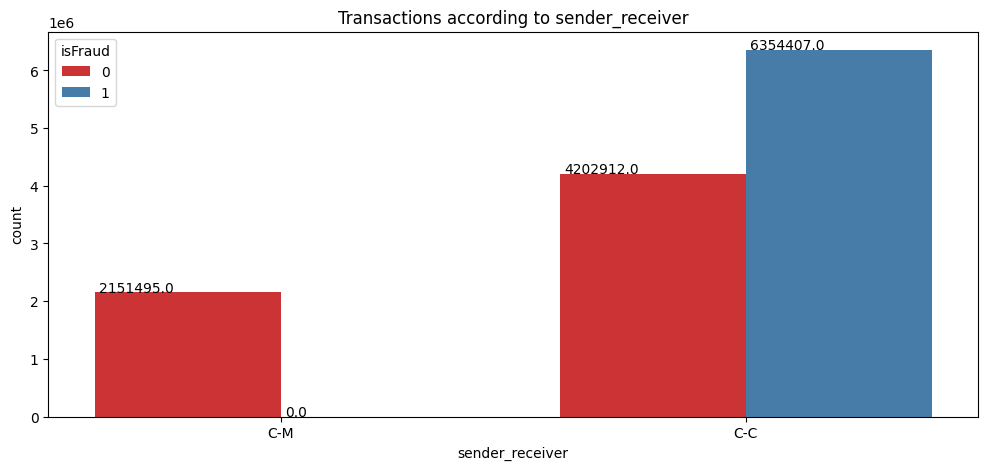

In [29]:
plt.figure(figsize = (12, 5))
plot=sns.countplot(data = fraud_data, x = "sender_receiver", hue="isFraud", palette = 'Set1')
plt.title('Transactions according to sender_receiver')
for p in plot.patches:
        plot.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

> This verifies that all the fradulent transactions are where both sender and receiver are customers.

**One hot encoding to get numerical values for modeling
**

In [30]:
final_data = pd.get_dummies(fraud_data, prefix = ['type', 'sender_receiver'], drop_first = True, dtype= int)

In [31]:
final_data.head()
final_data.shape

(12708814, 12)

Now it's time to split the dataset into training and testing part and then do the standardization.

In [32]:
X = final_data.drop(['isFraud'], axis=1)
Y = final_data.isFraud

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, stratify = final_data.isFraud)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Modeling

**Random Forest**


In [33]:
rf=RandomForestClassifier(n_estimators = 15, n_jobs = -1, random_state = 42)
rf.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=15, n_jobs=-1, random_state=42)

In [34]:
Y_predict=rf.predict(X_test)
Y_predict_proba = rf.predict_proba(X_test)[:,1]
rf_accuracy=accuracy_score(Y_test, Y_predict)
rf_auc= roc_auc_score(Y_test, Y_predict_proba)

print('Accuracy of RF:')
print(rf_accuracy)
print('AUC of RF:')
print(rf_auc)

Accuracy of RF:
0.9999596080935939
AUC of RF:
0.9999989508592987


**Gradient Boosted Decision Trees**

In [35]:
gbdt = xgb.XGBClassifier(max_depth = 3, n_jobs = -1, random_state = 42, learning_rate = 0.1)
gbdt.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [36]:
Y_predict=gbdt.predict(X_test)
Y_predict_proba = gbdt.predict_proba(X_test)[:,1]
gbdt_accuracy=accuracy_score(Y_test, Y_predict)
gbdt_auc= roc_auc_score(Y_test, Y_predict_proba)

print('Accuracy of Gradient Boosted Decision Trees:')
print(gbdt_accuracy)
print('AUC of Gradient Boosted Decision Trees:')
print(gbdt_auc)

Accuracy of Gradient Boosted Decision Trees:
0.988866784082966
AUC of Gradient Boosted Decision Trees:
0.9989396757072591


**Logestic Regression**

In [37]:
lgr = LogisticRegression(solver = 'liblinear', random_state = 42)
lgr.fit(X_train, Y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [38]:
Y_predict=lgr.predict(X_test)
Y_predict_proba = lgr.predict_proba(X_test)[:,1]
lgr_accuracy=accuracy_score(Y_test, Y_predict)
lgr_auc= roc_auc_score(Y_test, Y_predict_proba)

print('Accuracy of Logistic Regression Classifier:')
print(lgr_accuracy)
print('AUC of Logistic Regression Classifier:')
print(lgr_auc)

Accuracy of Logistic Regression Classifier:
0.9509107194611615
AUC of Logistic Regression Classifier:
0.9897788079933646


# Model Evaluation

**Classification Report**

**Random Forest**

In [39]:
print(classification_report(Y_test, rf.predict(X_test), target_names=['Not Fraud','Fraud']))


              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   1906322
       Fraud       1.00      1.00      1.00   1906323

    accuracy                           1.00   3812645
   macro avg       1.00      1.00      1.00   3812645
weighted avg       1.00      1.00      1.00   3812645



**Gradient Boosted Decision Trees**

In [40]:
print(classification_report(Y_test, gbdt.predict(X_test), target_names=['Not Fraud','Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99   1906322
       Fraud       0.98      1.00      0.99   1906323

    accuracy                           0.99   3812645
   macro avg       0.99      0.99      0.99   3812645
weighted avg       0.99      0.99      0.99   3812645



**Logestic Regression**

In [41]:
print(classification_report(Y_test, lgr.predict(X_test), target_names=['Not Fraud','Fraud']))

              precision    recall  f1-score   support

   Not Fraud       0.95      0.95      0.95   1906322
       Fraud       0.95      0.95      0.95   1906323

    accuracy                           0.95   3812645
   macro avg       0.95      0.95      0.95   3812645
weighted avg       0.95      0.95      0.95   3812645



> From the Classification report we see that random forest have achieved the precision and recall of 1.00 which is suggests that the model might have overfitted while Gradient Boosted Decision Trees gives the precion of 0.98 and Logistic Regression gives the precision of 0.95.

# Result and Conclusion

> We conclude that, Out of 6,362,620 transactions, there were 8,213 cases of fraud, involving either **CASH_OUT** or **TRANSFER** transactions within Customer to Customer accounts. After training thee algorithms, **Gradient Boosted Decision Tree** algorithm emerged as the top performer, achieving an  AUC score of 0.9 and accuracy of 98%.